Mounted at /content/drive

📥  STEP 1  Loading CSV files …


Reading:   0%|          | 0/8 [00:00<?, ?it/s]

   ✅ shape (2830743, 79) | ⏱ 40.7s

🧹  Dropped 8 constant cols
   ⏱ 41.0s

🔀  Classes kept: 15 | ⏱ 42.0s

🎨  STEP 5  Oversampling with SMOTE …
   ⚠️  Used CPU SMOTE → copied back to GPU
🚀  STEP 6  Training LogisticRegression (QN) on balanced set …
[2025-07-19 17:19:59.340] [CUML] [warning] L-BFGS: max iterations reached
[2025-07-19 17:19:59.342] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
   ✅ Accuracy (SMOTE + QN): 0.9117 | ⏱ 627.9s

=== Classification report ===
                             precision    recall  f1-score   support

                    BENIGN      1.000     0.891     0.942    454619
                       Bot      0.022     0.929     0.043       393
                      DDoS      0.948     0.999     0.973     25605
             DoS GoldenEye      0.590     0.970     0.734      2059
                  DoS Hulk      0.927  

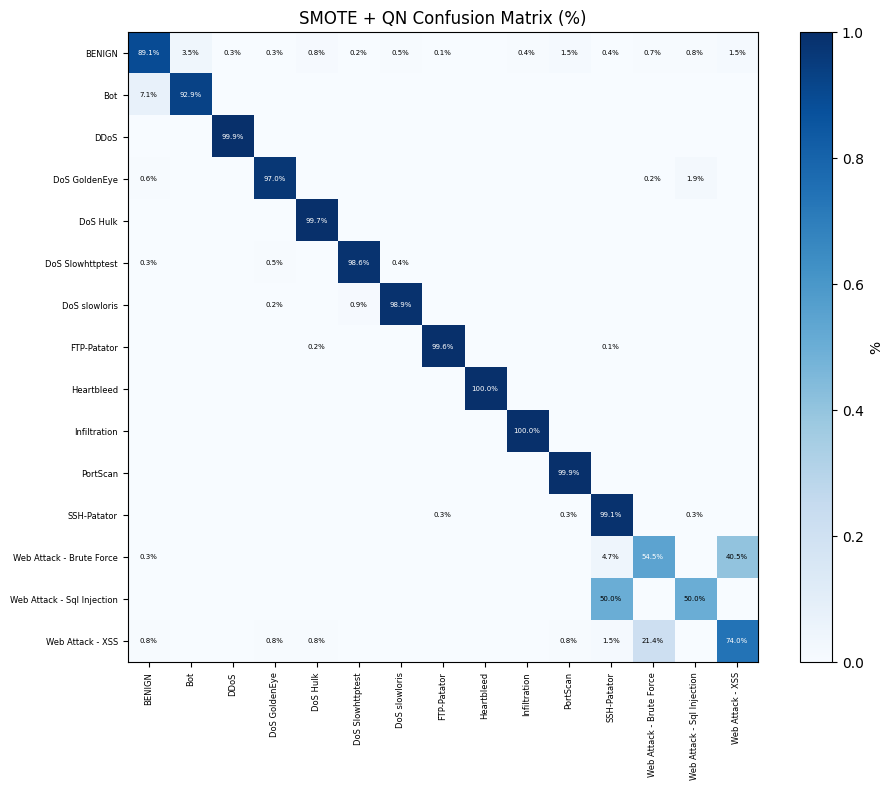


🏁  Finished in 630.9s | Accuracy=0.9117
Class distribution (train split, BEFORE SMOTE):
BENIGN                         1818478
Bot                            1573
DDoS                           102422
DoS GoldenEye                  8234
DoS Hulk                       184858
DoS Slowhttptest               4399
DoS slowloris                  4637
FTP-Patator                    6350
Heartbleed                     9
Infiltration                   29
PortScan                       127144
SSH-Patator                    4718
Web Attack - Brute Force       1206
Web Attack - Sql Injection     17
Web Attack - XSS               521

Class distribution (AFTER SMOTE):
BENIGN                         1818478
Bot                            454619
DDoS                           454619
DoS GoldenEye                  454619
DoS Hulk                       454619
DoS Slowhttptest               454619
DoS slowloris                  454619
FTP-Patator                    454619
Heartbleed                    

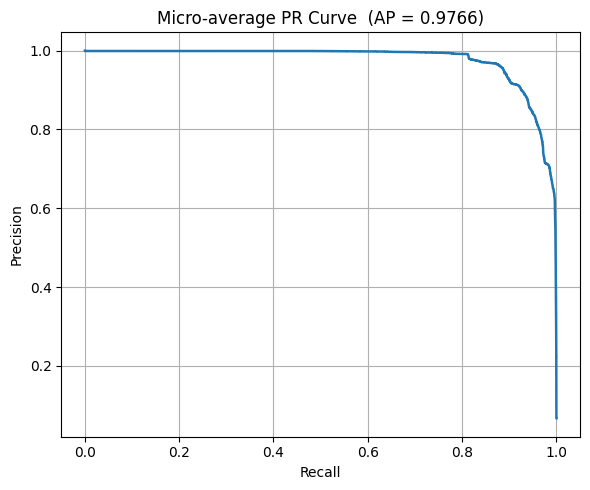

📊  STEP 10  Per-class precision/recall …


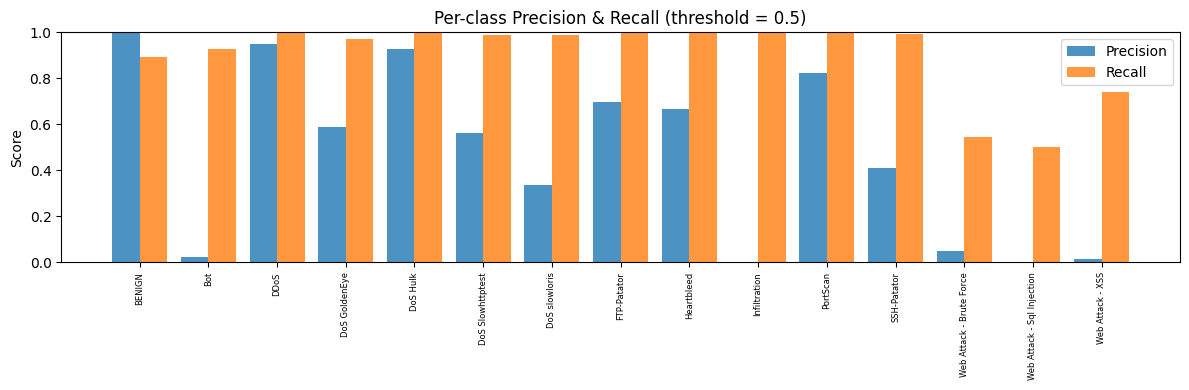

=== Classification report ===
                            precision    recall  f1-score   support

                    BENIGN      1.000     0.891     0.942    454619
                       Bot      0.022     0.929     0.043       393
                      DDoS      0.948     0.999     0.973     25605
             DoS GoldenEye      0.590     0.970     0.734      2059
                  DoS Hulk      0.927     0.997     0.960     46215
          DoS Slowhttptest      0.561     0.986     0.715      1100
             DoS slowloris      0.338     0.989     0.504      1159
               FTP-Patator      0.696     0.996     0.819      1588
                Heartbleed      0.667     1.000     0.800         2
              Infiltration      0.004     1.000     0.008         7
                  PortScan      0.825     0.999     0.903     31786
               SSH-Patator      0.411     0.991     0.581      1179
  Web Attack - Brute Force      0.051     0.545     0.093       301
Web Attack - Sql 

In [ ]:
# =========================================================
#   LogisticRegression (QN) + SMOTE  ——  RAPIDS 24.02
#   ▸ no baseline
#   ▸ keep all 15 original labels (no "Other")
# =========================================================
from google.colab import drive
import os
drive.mount('/content/drive')

from pathlib import Path
from time import perf_counter
from collections import Counter

import cudf, cupy as cp, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
from cuml.linear_model import LogisticRegression          # QN solver only
from cuml.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

CONFIG = {
    "data_dir": "/content/drive/My Drive/Colab Notebooks/MachineLearningCVE",
    "test_size": 0.20,
    "smote_ratio": 0.25,      # minority → 25 % of majority
    "use_dask": False         # True if CSV huge / GPU RAM tight
}

t0 = perf_counter()

# ---------- STEP 1: Load CSV ----------------------------------------------
print("\n📥  STEP 1  Loading CSV files …")
DATA_DIR = Path(CONFIG["data_dir"])
csv_files = sorted(DATA_DIR.glob("*.csv"))

if CONFIG["use_dask"]:
    import dask_cudf as dd
    df = dd.read_csv(str(DATA_DIR / "*.csv"), blocksize="256MB").compute()
else:
    df = cudf.concat([cudf.read_csv(f) for f in tqdm(csv_files, desc="Reading")],
                     ignore_index=True)
print(f"   ✅ shape {df.shape} | ⏱ {perf_counter()-t0:.1f}s\n")

# ---------- STEP 2: Clean columns -----------------------------------------
df.columns = df.columns.str.strip()
df = df.drop(columns=[c for c in df.columns if c.lower() in
                      ["flow id", "source ip", "destination ip", "timestamp"]],
             errors="ignore")

const_cols = df.nunique().to_pandas().pipe(lambda s: s[s <= 1]).index.tolist()
if const_cols:
    df = df.drop(columns=const_cols)
    print(f"🧹  Dropped {len(const_cols)} constant cols")
print(f"   ⏱ {perf_counter()-t0:.1f}s\n")

# ---------- STEP 3: Label encoding (keep all 15) ---------------------------
label_col = [c for c in df.columns if c.lower() == "label"][0]
y_raw = (df.pop(label_col).fillna("UNKNOWN").astype("str")
           .str.replace("–", "-").str.replace("—", "-").str.strip())
# 替换 y_raw 中的乱码标签为正常格式
y_raw = y_raw.replace({
    "Web Attack � Brute Force": "Web Attack - Brute Force",
    "Web Attack � Sql Injection": "Web Attack - Sql Injection",
    "Web Attack � XSS": "Web Attack - XSS"
})

attack_types = sorted(y_raw.unique().to_pandas())     # 15 original labels
atk2idx = {n: i for i, n in enumerate(attack_types)}
idx2atk = {i: n for n, i in atk2idx.items()}

y = y_raw.map(atk2idx).astype("int32")
X = df.astype("float32").fillna(0).replace([cp.inf, -cp.inf], 0)
print(f"🔀  Classes kept: {len(attack_types)} | ⏱ {perf_counter()-t0:.1f}s\n")

# ---------- STEP 4: Train/test split & scaling ----------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=CONFIG["test_size"], stratify=y, random_state=42)

scaler = StandardScaler(with_mean=False)
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

# ---------- STEP 5: SMOTE --------------------------------------------------
print("🎨  STEP 5  Oversampling with SMOTE …")
try:
    from cuml.experimental.preprocessing import SMOTE as cuSMOTE
    smote = cuSMOTE(random_state=42, sampling_strategy=CONFIG["smote_ratio"])
    X_sm, y_sm = smote.fit_resample(X_tr_s, y_tr)
    print("   ✅ Used cuML GPU-SMOTE")
except (ImportError, AttributeError):
    from imblearn.over_sampling import SMOTE
    cls_cnt = Counter(y_tr.to_numpy())
    maj = max(cls_cnt.values())
    tgt = int(maj * CONFIG["smote_ratio"])
    sm_dict = {cls: tgt for cls, cnt in cls_cnt.items() if cnt < tgt}
    #smote = SMOTE(random_state=42, sampling_strategy=sm_dict, n_jobs=-1)
    smote = SMOTE(random_state=42, sampling_strategy=sm_dict)
    X_cpu, y_cpu = smote.fit_resample(X_tr_s.to_numpy(), y_tr.to_numpy())
    X_sm, y_sm = cp.asarray(X_cpu), cp.asarray(y_cpu)
    print("   ⚠️  Used CPU SMOTE → copied back to GPU")

# ---------- STEP 6: Train LogisticRegression (QN) --------------------------
print("🚀  STEP 6  Training LogisticRegression (QN) on balanced set …")
clf = LogisticRegression(max_iter=1500, C=0.8, penalty="l2", solver="qn")
clf.fit(X_sm, y_sm)

y_pred = clf.predict(X_te_s)
acc = accuracy_score(y_te, y_pred)
print(f"   ✅ Accuracy (SMOTE + QN): {acc:.4f} | ⏱ {perf_counter()-t0:.1f}s\n")

# ---------- STEP 7: Report & Confusion Matrix -----------------------------
print("=== Classification report ===\n",
      classification_report(y_te.to_numpy(), y_pred.to_numpy(),
                            target_names=attack_types, digits=3))

def plot_cm(cm, title):
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(10, 8))
    plt.imshow(cmn, cmap="Blues")
    plt.title(title); plt.colorbar(label="%")
    plt.xticks(range(len(attack_types)), attack_types, rotation=90, fontsize=6)
    plt.yticks(range(len(attack_types)), attack_types, fontsize=6)
    thr = cmn.max() / 2
    for i in range(cmn.shape[0]):
        for j in range(cmn.shape[1]):
            v = cmn[i, j]
            if v > 0.001:
                plt.text(j, i, f"{v*100:.1f}%",
                         ha="center", va="center",
                         color="white" if v > thr else "black",
                         fontsize=5)
    plt.tight_layout(); plt.show()

plot_cm(confusion_matrix(y_te, y_pred).get(), "SMOTE + QN Confusion Matrix (%)")
print(f"\n🏁  Finished in {perf_counter()-t0:.1f}s | Accuracy={acc:.4f}")

# ---------- Class distribution BEFORE SMOTE ----------
print("Class distribution (train split, BEFORE SMOTE):")
counts_before = cudf.Series(y_tr).value_counts().to_pandas()  # → pandas 方便迭代
for cls_id in range(len(attack_types)):
    label = attack_types[cls_id]
    cnt   = counts_before.get(cls_id, 0)
    print(f"{label:<30} {cnt}")

# ---------- Class distribution AFTER SMOTE -----------
print("\nClass distribution (AFTER SMOTE):")
counts_after = cudf.Series(y_sm).value_counts().to_pandas()
for cls_id in range(len(attack_types)):
    label = attack_types[cls_id]
    cnt   = counts_after.get(cls_id, 0)
    print(f"{label:<30} {cnt}")

# ---------- STEP 8: Precision-Recall Curve (micro-average) ---------------
print("📈  STEP 8  Plotting Precision-Recall curve …")

from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1) 预测概率: DataFrame → cupy ndarray → numpy
proba_df = clf.predict_proba(X_te_s)        # cudf.DataFrame, shape=(n_samples, n_classes)
y_score   = proba_df.values                 # cupy ndarray on GPU
y_score   = y_score.get()                   # numpy array on CPU  ← 适配 sklearn

# 2) One-hot label 矩阵
y_test_bin = label_binarize(
    y_te.to_numpy(), classes=list(range(len(attack_types)))
)

# 3) 微平均 PR 曲线
precision, recall, _ = precision_recall_curve(
    y_test_bin.ravel(), y_score.ravel()
)
ap_micro = average_precision_score(
    y_test_bin, y_score, average="micro"
)

# 4) 绘图
plt.figure(figsize=(6, 5))
plt.step(recall, precision, where="post", linewidth=1.8)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Micro-average PR Curve  (AP = {ap_micro:.4f})")
plt.grid(True); plt.tight_layout(); plt.show()

# ---------- STEP 10: Per-class Precision & Recall bars --------------------
print("📊  STEP 10  Per-class precision/recall …")

import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# ――― 方法 A：直接复用 y_te / y_pred ―――
y_test_cpu = y_te.to_numpy()            # cudf.Series → numpy
y_pred_cpu = y_pred.to_numpy()          # cudf.Series → numpy
#      如果你手头没有 y_pred，也可以用 clf.predict(X_te_s).to_numpy()

prec, rec, _, _ = precision_recall_fscore_support(
    y_test_cpu, y_pred_cpu, zero_division=0, labels=list(range(len(attack_types)))
)

# ――― 方法 B：用概率阈值自行裁剪 ―――
#   如果你想用别的阈值而不是 0.5，可把下面两行改掉：
# y_pred_alt = (y_score.argmax(axis=1))         # 按最大概率选类
# prec, rec, _, _ = precision_recall_fscore_support(
#     y_test_cpu, y_pred_alt, zero_division=0, labels=list(range(len(attack_types)))
# )

# ---------- 画条形图 -------------------------------------------------------
ind   = np.arange(len(attack_types))
width = 0.4

plt.figure(figsize=(12, 4))
plt.bar(ind - width/2, prec, width, label="Precision", alpha=0.8)
plt.bar(ind + width/2, rec,  width, label="Recall",    alpha=0.8)

plt.xticks(ind, attack_types, rotation=90, fontsize=6)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Per-class Precision & Recall (threshold = 0.5)")
plt.legend()
plt.tight_layout()
plt.show()

aps = []
for i, name in enumerate(attack_types):
    ap_i = average_precision_score(y_test_bin[:, i], y_score[:, i])
    aps.append({"label": name, "AP": ap_i})

import pandas as pd
pd.DataFrame(aps).sort_values("AP", ascending=False)

# ---------- STEP 7-bis: Classification report ----------------------------
print("=== Classification report ===")
from sklearn.metrics import classification_report

# cuDF → NumPy（sklearn 只能吃 CPU numpy）
y_true_np = y_te.to_numpy()
y_pred_np = y_pred.to_numpy()

# target_names 保持与你的 attack_types 顺序一致
report = classification_report(
    y_true_np,
    y_pred_np,
    target_names=attack_types,   # 15 个类别名称
    digits=3,                   # 保留 3 位小数，和示例一致
    zero_division=0             # 防止某类 precision/recall 为 0 时报 Warning
)

print(report)

# ---------- STEP 8: Map Labels to MITRE ATT&CK IDs ------------------------
print("\n🔐 STEP 8  Mapping labels to MITRE ATT&CK techniques …")

# 自定义 label 到 MITRE TTP 的映射（示例）
mitre_map = {
    "BENIGN": "N/A",
    "Bot": "T1071.001",                 # Application Layer Protocol: Web Protocols
    "DDoS": "T1499",                    # Endpoint Denial of Service
    "DoS GoldenEye": "T1499.004",      # Network Denial of Service: Application Layer Flood
    "DoS Hulk": "T1499.004",
    "DoS Slowhttptest": "T1499.004",
    "DoS slowloris": "T1499.004",
    "FTP-Patator": "T1110.001",        # Brute Force: Password Guessing
    "Heartbleed": "T1210",             # Exploitation of Remote Services
    "Infiltration": "T1059",           # Command and Scripting Interpreter
    "PortScan": "T1046",               # Network Service Scanning
    "SSH-Patator": "T1110.003",        # Brute Force: SSH
    "Web Attack - Brute Force": "T1110",
    "Web Attack - Sql Injection": "T1190",
    "Web Attack - XSS": "T1059.007",
    "UNKNOWN": "T1588.001"             # Obfuscation / Unlabeled traffic
}

# 构建 DataFrame
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_te.to_numpy(), y_pred.to_numpy(), zero_division=0
)

mitre_table = pd.DataFrame({
    "Label": attack_types,
    "MITRE TTP": [mitre_map.get(lbl, "TXXXX") for lbl in attack_types],
    "Precision": precision.round(3),
    "Recall": recall.round(3),
    "F1-Score": f1.round(3),
    "Support": support
}).sort_values("Label").reset_index(drop=True)

print("\n=== MITRE ATT&CK Mapping Table ===\n")
print(mitre_table.to_string(index=False))

